<a href="https://colab.research.google.com/github/dmbrundage88/genomic_datascience/blob/main/nuclei_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount google drive
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Load modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from os.path import join
import glob
import sys
import random
import warnings
from tqdm import tqdm
import itertools
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Conv2D, UpSampling2D, Lambda
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
#import keras.backend.tensorflow_backend as K
# Remember to enable GPU
%matplotlib inline

In [ ]:
#path to image of segmented nuclei images and masks
image_path = "/content/gdrive/My Drive/nuclei_test/test/images/"
masks_path = "/content/gdrive/My Drive/nuclei_test/test/masks/"

In [ ]:
#get list of files in each directory
images = os.listdir(image_path)
masks = os.listdir(masks_path)

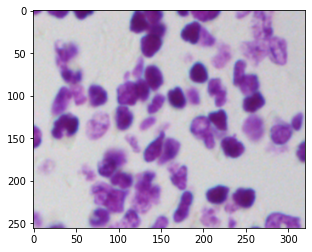

In [ ]:
#Display the image
for image in images:
  img = cv2.imread(image_path+image)
  img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img_cvt)
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


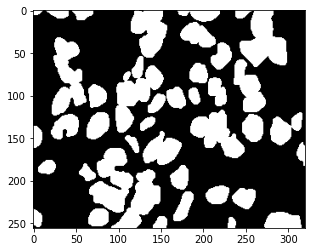

In [ ]:
#combine each mask into one
result = np.zeros((256,320,3))
for image in masks:
  img = cv2.imread(masks_path+image)
  result = result+img
plt.imshow(result)

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [ ]:
top_path = "/content/gdrive/My Drive/segmented_nuclei_images/"
i=0
for dir in os.listdir(top_path):
  for img in os.listdir(top_path+dir+'/'+'images/'):
    img = cv2.imread(top_path+dir+'/'+'images/'+img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    cv2.imwrite("/content/gdrive/My Drive/nuclei_test/x_train/"+str(i)+'.png',img)
  i+=1 

In [ ]:
top_path = "/content/gdrive/My Drive/segmented_nuclei_images/"
i=0
for dir in os.listdir(top_path):
  result = np.zeros((256,256,3))
  for img in os.listdir(top_path+dir+'/'+'masks/'):
    image = cv2.imread(top_path+dir+'/'+'masks/'+img)
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    result = result+image
  cv2.imwrite("/content/gdrive/My Drive/nuclei_test/y_train/"+str(i)+'.png',result)
  i+=1

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
# Set some parameters
X_PATH = "/content/gdrive/My Drive/nuclei_test/X/"
Y_PATH = "/content/gdrive/My Drive/nuclei_test/Y/"

seed = 42
random.seed = seed
np.random.seed = seed

# Get train and test IDs
X_ids = os.listdir(X_PATH)

# Get and resize train images and masks
X = np.zeros((len(X_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(X_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id in enumerate(X_ids):
    img = imread(X_PATH  + id )[:,:,:IMG_CHANNELS]
    X[n] = img
    mask = imread(Y_PATH  + id)[:,:,:1]
    Y[n] = mask



#x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
print('X',X.shape)
print('Y',Y.shape)

Getting and resizing train images and masks ... 
X (659, 256, 256, 3)
Y (659, 256, 256, 1)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print('\nx_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)


x_train (527, 256, 256, 3)
x_test (132, 256, 256, 3)
y_train (527, 256, 256, 1)
y_test (132, 256, 256, 1)


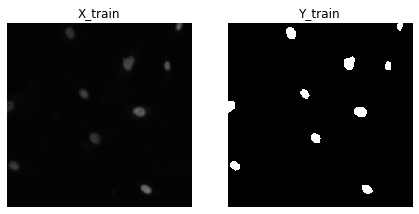

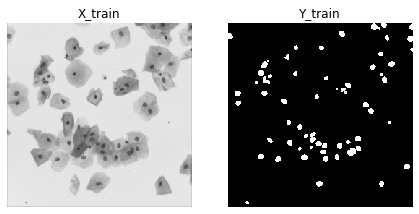

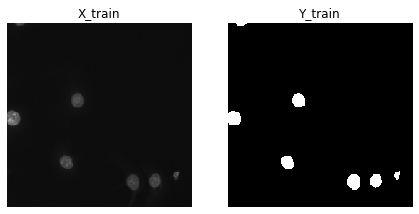

In [ ]:
def plotTrainData(a,b):
    for i in range(3):
        ix = random.randint(0, 527)
        plt.subplot(1,2,1)
        plt.title("X_train")
        imshow(a[ix])
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title("Y_train")
        imshow(np.squeeze(b[ix]))
        plt.axis('off')
        plt.show()
plotTrainData(x_train,y_train)

In [ ]:
from datetime import datetime
import time

class LogMetrics(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)


def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

class timecallback(Callback):
  def __init__(self):
    self.times=[]
    self.timetaken = time.clock()
  def on_epoch_end(self, epoch, logs=None):
    self.times.append((epoch, time.clock()-self.timetaken))
  def on_train_end(self,logs={}):
    plt.xlabel('Epoch')
    plt.ylabel('Total time taken until an Epoch in seconds')
    plt.plot(*zip(*self.times))
    plt.show()
  



Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 256, 256, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 256, 256, 16) 448         lambda_9[0][0]                   
__________________________________________________________________________________________________
dropout_81 (Dropout)            (None, 256, 256, 16) 0           conv2d_171[0][0]                 
______________________________________________________________________________________

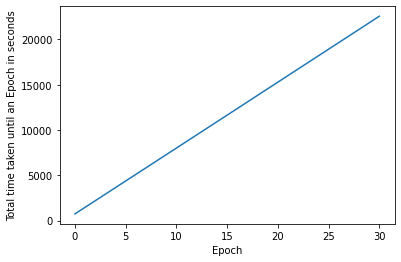

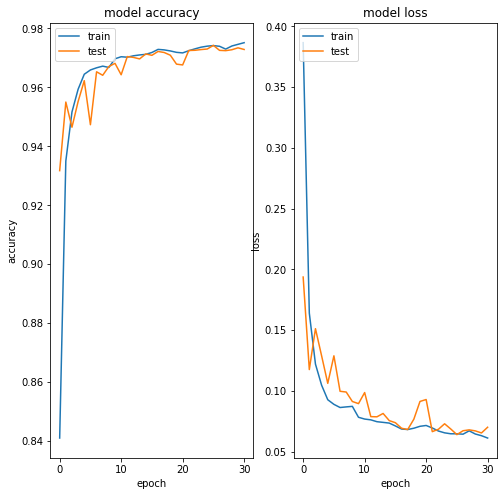

NameError: ignored

In [ ]:
def UNET(a,b,c,d):
    # Build U-Net model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    model.summary()
    # Fit model
    earlystopper = EarlyStopping(patience=5, verbose=1)
    checkpointer = ModelCheckpoint('model-nuclei_segmentation'.h5', verbose=1, save_best_only=True)
    timetaken=timecallback()
    results = model.fit(a,b,batch_size=16,verbose=1,epochs=40,validation_data=(c,d),callbacks = [earlystopper, checkpointer, LogMetrics('logs'), timetaken])
    plot_learning_curve(results)
    plt.show()
    #plotKerasLearningCurve()
    global times
    times = epoch_time_results(results)
    plt.show()
    global modelZ
    modelZ = model
    return modelZ, times
UNET(x_train, y_train,x_test,y_test)

In [ ]:
def plotPredictions(a,b,c,d,e):
    model = e
    # Threshold predictions
    preds_train = model.predict(a[:int(a.shape[0]*0.9)], verbose=1)
    preds_val = model.predict(a[int(a.shape[0]*0.9):], verbose=1)
    preds_test = model.predict(c, verbose=1)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    # Perform a sanity check on some random training samples
    ix = random.randint(0, len(preds_train_t))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    imshow(a[ix])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    imshow(np.squeeze(b[ix]))
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.axis('off')
    imshow(np.squeeze(preds_train_t[ix]))
    plt.show()
    # Perform a sanity check on some random validation samples
    ix = random.randint(0, len(preds_val_t))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    imshow(a[int(a.shape[0]*0.9):][ix])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    imshow(np.squeeze(b[int(b.shape[0]*0.9):][ix]))
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.axis('off')
    imshow(np.squeeze(preds_val_t[ix]))
    plt.show()

5/5 [==============================] - 0s 66ms/step


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


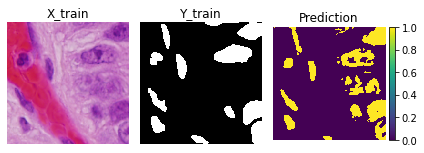

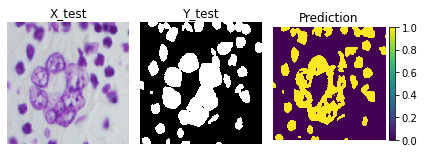

In [ ]:
plotPredictions(x_train,y_train,x_test,y_test,modelZ)